In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_data = pd.read_csv('../input/titanic/train.csv')
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

## Visualization

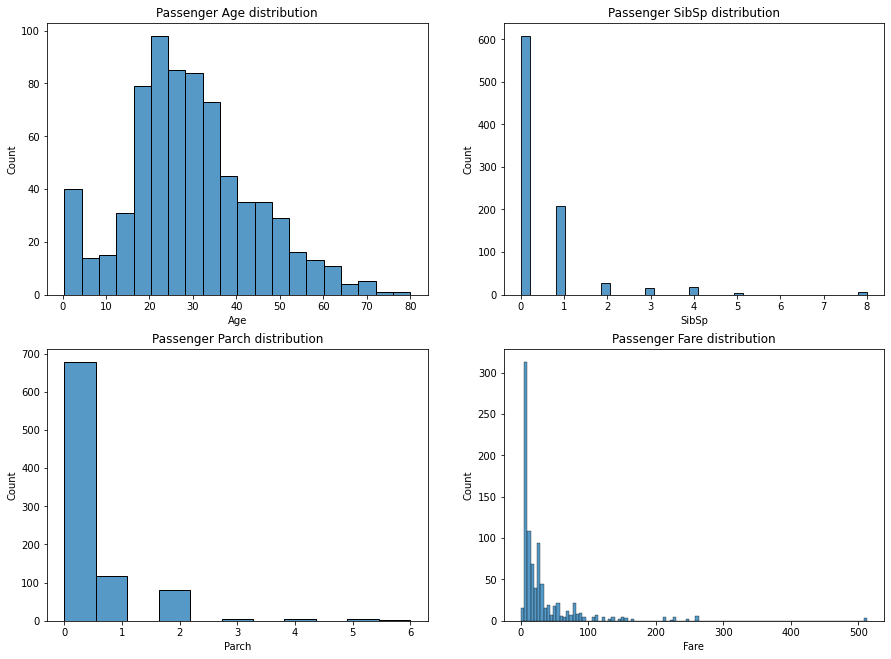

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

cols = ['Age', 'SibSp', 'Parch', 'Fare']
fig, ax = plt.subplots(2, 2, figsize = (15, 11))
c = 0
for i in range(2):
    for j in range(2):
        sns.histplot(train_data[cols[c]], ax = ax[i, j])
        ax[i, j].set_title(f'Passenger {cols[c]} distribution')
        c += 1

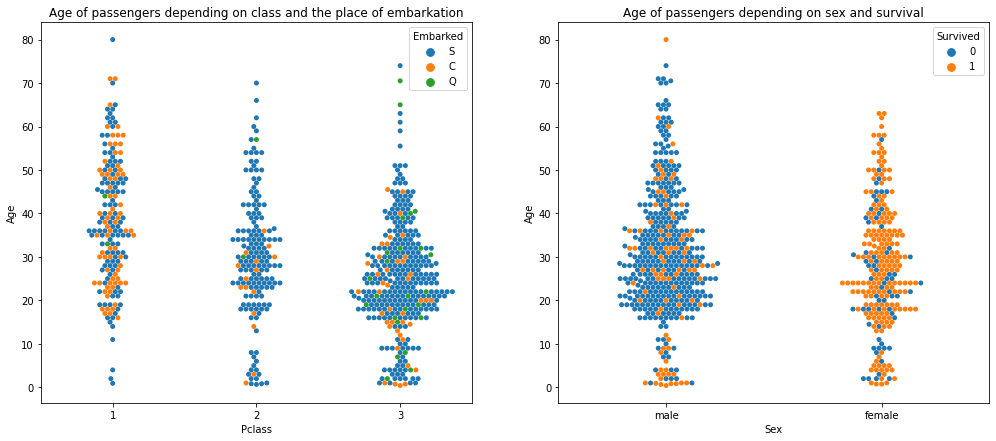

In [6]:
fig, ax = plt.subplots(1, 2, figsize = (17, 7))

sns.swarmplot(x = train_data['Pclass'], y = train_data['Age'], hue = train_data['Embarked'], ax = ax[0])
ax[0].set_title('Age of passengers depending on class and the place of embarkation')

sns.swarmplot(x = train_data['Sex'], y = train_data['Age'], hue = train_data['Survived'], ax = ax[1])
ax[1].set_title('Age of passengers depending on sex and survival')

plt.show()

## Drop useless columns and handle missing values

In [7]:
df = train_data.copy().drop(['PassengerId', 'Ticket', 'Cabin', 'Name'], axis = 1)
df.Age = df.Age.fillna(df.Age.mean())
df.Embarked = df.Embarked.fillna(df.Embarked.mode()[0])

## Case 1: ordinal encoding
### Data preprocessing

In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder

X1 = df.copy()
y1 = X1.pop('Survived')

ordinal_encoder = OrdinalEncoder()
X1[['Sex', 'Embarked']] = ordinal_encoder.fit_transform(X1[['Sex', 'Embarked']])

est = [100, 150, 200]
min_samp = [3, 4, 5, 6, 7, 8]

X1.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,1.0,22.0,1,0,7.2500,2.0
1,1,0.0,38.0,1,0,71.2833,0.0
2,3,0.0,26.0,0,0,7.9250,2.0
3,1,0.0,35.0,1,0,53.1000,2.0
4,3,1.0,35.0,0,0,8.0500,2.0


### Training the model and getting scores

In [9]:
est_result1 = []
min_samp_result1 = []
score_result1 = []

for i in est:
    for j in min_samp:
        score = -1 * cross_val_score(RandomForestClassifier(n_estimators = i, min_samples_split = j, random_state = 1),
                                     X1, y1, cv = 5, scoring = 'neg_mean_absolute_error')
        est_result1.append(i)
        min_samp_result1.append(j)
        score_result1.append(score.mean())
        
result1 = pd.DataFrame({'n_estimators': est_result1, 'min_samples_split': min_samp_result1, 'score': score_result1})

### Results

In [10]:
result1.sort_values(by = ['score']).head(10)

,n_estimators,min_samples_split,score
17,200,8,0.164961
5,100,8,0.164974
4,100,7,0.166079
14,200,5,0.167202
8,150,5,0.167202
2,100,5,0.167202
16,200,7,0.168320
10,150,7,0.168326
11,150,8,0.169443
9,150,6,0.169450


## Case 2: one-hot encoding
### Data preprocessing

In [11]:
from sklearn.preprocessing import OneHotEncoder

X2 = df.copy()
y2 = X2.pop('Survived')

OH_encoder = OneHotEncoder(handle_unknown = 'ignore', sparse = False)
OH_cols = pd.DataFrame(OH_encoder.fit_transform(X2[['Pclass', 'Sex', 'Embarked']]))

num_X2 = X2.drop(['Pclass', 'Sex', 'Embarked'], axis = 1)
OH_X2 = pd.concat([num_X2, OH_cols], axis = 1)

for i in range(8):
    OH_X2 = OH_X2.rename(columns = {i: str(i)})

OH_X2.head()

,Age,SibSp,Parch,Fare,0,1,2,3,4,5,6,7
0,22.0,1,0,7.2500,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,38.0,1,0,71.2833,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,26.0,0,0,7.9250,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,35.0,1,0,53.1000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,35.0,0,0,8.0500,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


### Training the model and getting scores

In [12]:
est_result2 = []
min_samp_result2 = []
score_result2 = []

for i in est:
    for j in min_samp:
        score = -1 * cross_val_score(RandomForestClassifier(n_estimators = i, min_samples_split = j, random_state = 1),
                                     OH_X2, y2, cv = 5, scoring = 'neg_mean_absolute_error')
        est_result2.append(i)
        min_samp_result2.append(j)
        score_result2.append(score.mean())
        
result2 = pd.DataFrame({'n_estimators': est_result2, 'min_samples_split': min_samp_result2, 'score': score_result2})

### Results

In [13]:
result2.sort_values(by = ['score']).head(10)

,n_estimators,min_samples_split,score
16,200,7,0.168320
3,100,6,0.170561
10,150,7,0.171665
15,200,6,0.171684
7,150,4,0.171690
4,100,7,0.172795
17,200,8,0.173931
1,100,4,0.173931
11,150,8,0.173931
14,200,5,0.173938


## Case 3: 2nd case + standartization
### Data preprocessing

In [14]:
from sklearn.preprocessing import StandardScaler

X3 = OH_X2.copy()
y3 = df['Survived'].copy()

scaler = StandardScaler()
scaler.fit(X3)
X3_std = pd.DataFrame(scaler.transform(X3))
X3_std.columns = X3.columns

X3_std.head()

,Age,SibSp,Parch,Fare,0,1,2,3,4,5,6,7
0,-0.592481,0.432793,-0.473674,-0.502445,-0.565685,-0.510152,0.902587,-0.737695,0.737695,-0.482043,-0.307562,0.615838
1,0.638789,0.432793,-0.473674,0.786845,1.767767,-0.510152,-1.107926,1.355574,-1.355574,2.074505,-0.307562,-1.623803
2,-0.284663,-0.474545,-0.473674,-0.488854,-0.565685,-0.510152,0.902587,1.355574,-1.355574,-0.482043,-0.307562,0.615838
3,0.407926,0.432793,-0.473674,0.420730,1.767767,-0.510152,-1.107926,1.355574,-1.355574,-0.482043,-0.307562,0.615838
4,0.407926,-0.474545,-0.473674,-0.486337,-0.565685,-0.510152,0.902587,-0.737695,0.737695,-0.482043,-0.307562,0.615838


### Training the model and getting scores

In [15]:
est_result3 = []
min_samp_result3 = []
score_result3 = []

for i in est:
    for j in min_samp:
        score = -1 * cross_val_score(RandomForestClassifier(n_estimators = i, min_samples_split = j, random_state = 1),
                                     X3_std, y3, cv = 5, scoring = 'neg_mean_absolute_error')
        est_result3.append(i)
        min_samp_result3.append(j)
        score_result3.append(score.mean())
        
result3 = pd.DataFrame({'n_estimators': est_result3, 'min_samples_split': min_samp_result3, 'score': score_result3})

### Results

In [16]:
result3.sort_values(by = ['score']).head(10)

,n_estimators,min_samples_split,score
16,200,7,0.168320
15,200,6,0.170567
10,150,7,0.171665
7,150,4,0.171684
3,100,6,0.171690
4,100,7,0.172801
11,150,8,0.172808
14,200,5,0.172814
8,150,5,0.173931
17,200,8,0.173931


## Public scores in the Titanic competition
Here are the scores i got using the best performance parameters in each case:
- Case 1 - 0.76315
- Case 2 - 0.77751
- Case 3 - 0.78947